1. Initializations and Dataset Download

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


2. Imports

In [2]:
import torch 
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from PIL import Image 
import pandas as pd 
import numpy as np 
import os 

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cpu


3. Reading Data Paths

In [3]:
image_path = []  
labels = []  

for i in os.listdir("./animal-faces/afhq/"):
    for label in os.listdir(f"./animal-faces/afhq/{i}"):
        for image in os.listdir(f"./animal-faces/afhq/{i}/{label}"):
            labels.append(label)
            image_path.append(f"./animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head()  

,image_paths,labels
0,./animal-faces/afhq/train/cat/pixabay_cat_0004...,cat
1,./animal-faces/afhq/train/cat/pixabay_cat_0019...,cat
2,./animal-faces/afhq/train/cat/pixabay_cat_0046...,cat
3,./animal-faces/afhq/train/cat/pixabay_cat_0022...,cat
4,./animal-faces/afhq/train/cat/pixabay_cat_0025...,cat


4. Data Split

In [4]:
train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index) 

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index) 

5. Preprocessing Objects

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels']) 

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.ConvertImageDtype(torch.float)
    ])

6. Custom Dataset Class

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

7. Create Dataset Objects

In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

8. Visualize Images

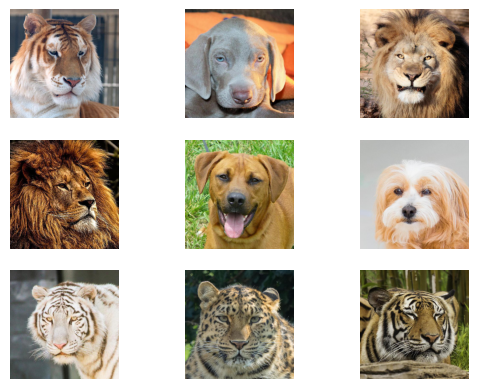

In [8]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

9. Hyperparameters

In [9]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

10. DataLoaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

11. Model

In [11]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) 
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2) 
      self.relu = nn.ReLU() 

      self.flatten = nn.Flatten()
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x) 
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x) 
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x) 
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)


12. Model Summary

In [12]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

13. Loss and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

14. Training

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.3444 Train Accuracy 80.1523
              Validation Loss: 0.3682 Validation Accuracy: 91.6942
Epoch 2/10, Train Loss: 1.3616 Train Accuracy 93.2778
              Validation Loss: 0.2493 Validation Accuracy: 94.1322
Epoch 3/10, Train Loss: 0.864 Train Accuracy 95.7223
              Validation Loss: 0.194 Validation Accuracy: 95.5372
Epoch 4/10, Train Loss: 0.5859 Train Accuracy 97.1216
              Validation Loss: 0.2052 Validation Accuracy: 94.8347
Epoch 5/10, Train Loss: 0.4192 Train Accuracy 97.9187
              Validation Loss: 0.1689 Validation Accuracy: 96.1157
Epoch 6/10, Train Loss: 0.3148 Train Accuracy 98.4501
              Validation Loss: 0.1465 Validation Accuracy: 96.6529
Epoch 7/10, Train Loss: 0.2356 Train Accuracy 98.8398
              Validation Loss: 0.1795 Validation Accuracy: 96.157
Epoch 8/10, Train Loss: 0.168 Train Accuracy 99.2472
              Validation Loss: 0.224 Validation Accuracy: 95.5372
Epoch 9/10, Train Loss: 0.1562 Train 

15. Testing

In [15]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.1141 and Loss is 0.0211


16. Plotting Training Progress

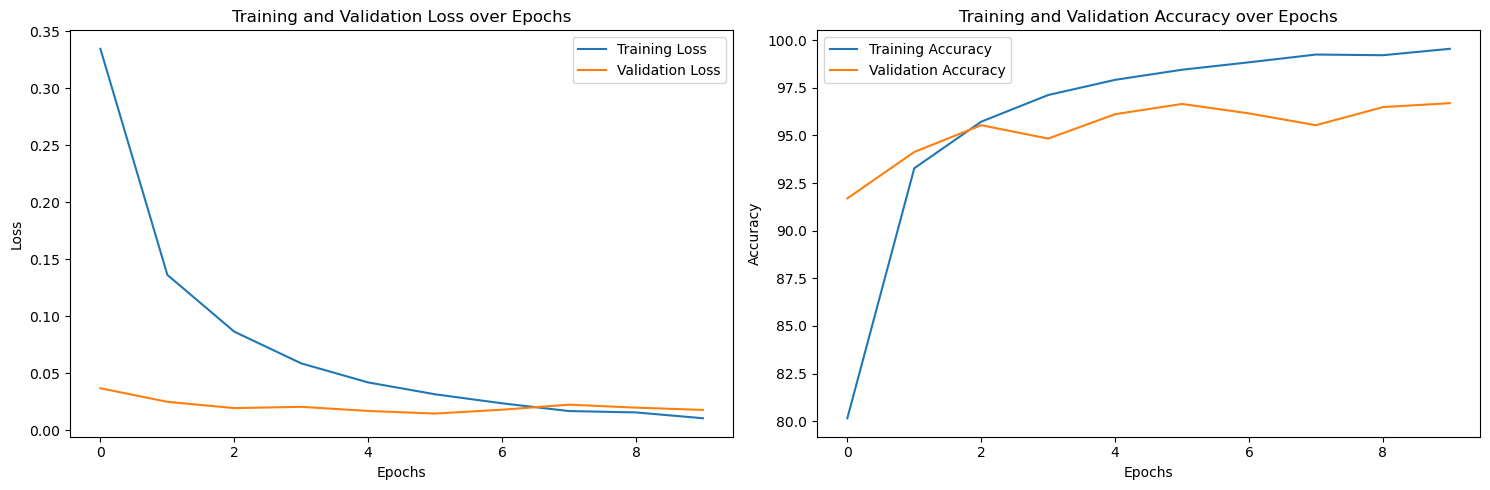

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

17. Inference

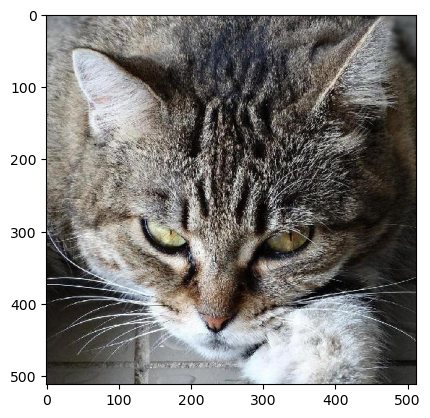


Prediction: 



array(['cat'], dtype=object)

In [20]:
test_image_path = "./animal-faces/afhq/val/cat/pixabay_cat_002256.jpg"
image = Image.open(test_image_path)
plt.imshow(image)
plt.show()

print()
print("Prediction: \n")
predict_image(test_image_path)

In [19]:
import os
print(os.listdir("./animal-faces/afhq/val/cat/")[:5])  # Show first 5 files

['pixabay_cat_002256.jpg', 'pixabay_cat_000441.jpg', 'flickr_cat_000802.jpg', 'flickr_cat_000816.jpg', 'flickr_cat_000180.jpg']
